In [132]:
import pathlib, joblib, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

FILE = pathlib.Path("schizophrenia.xlsx")
df   = pd.read_excel(FILE)

df = df.dropna(thresh=len(df)*0.60, axis=1)

In [133]:

str_cols = df.select_dtypes(include="object").columns
df[str_cols] = df[str_cols].apply(lambda c: c.str.strip().str.upper())

In [134]:
common_maps = {
    "MARITAL" : {"SINGLE":"SINGLE", "SINGL":"SINGLE", "SINGLEE":"SINGLE"},
    "SEX"     : {"M":"MALE", "F":"FEMALE"},
    "CLASS"   : {"SHIZ":"SCHIZ", "SHICZ":"SCHIZ"},
        
}
global_maps = {
    "Y": "YES", "N": "NO", "NO": "NO", "N0": "NO", "YES": "YES",
    "ALLEGIES": "ALLERGIES",
    "NOT KNOWN": "UNKNOWN",
    "NOT KEMPT": "UNKEMPT",
    "COMPPREHENSABLE": "COMPREHENSIBLE",
    "REDUCED VOL": "DECREASED TONE", "REDUCED": "DECREASED TONE", "DECREASED TONE": "DECREASED TONE",
    "G": "GOOD", "GOOD": "GOOD", "LA": "LACKING", "LACKIN": "LACKING", "LACKING": "LACKING",
    "ROUSABLE": "AROUSABLE", "ARROUSABLE": "AROUSABLE", "AROUSABLE": "AROUSABLE",
    "NOT ORIENTED": "NOT ORIENTED IN TPP", "NOT ORIENTED IN TPP": "NOT ORIENTED IN TPP", "ORIENTED IN TPP": "ORIENTED IN TPP",
    "AUDITORY": "AUDITORY HALLUCINATION", "AUDITORY HALLUCINATION": "AUDITORY HALLUCINATION",
    "AUDOTORY HALLUCINATION": "AUDITORY HALLUCINATION", "OLFACTORY HALLUCINATION": "OLFACTORY HALLUCINATION",
    "AUDI TORY DELUSION": "AUDITORY HALLUCINATION", "BIZARE DELIRIUM": "BIZZARE DELUSION",
    "DELUSION OF REFERENCE": "DELUSION OF REFERENCE", "GRANDEUR DELUSION": "GRANDIOSE DELUSION",
    "GRANDIOSE": "GRANDIOSE DELUSION",
    "DERAILMEN": "DERAILMENT", "DERAILMENT": "DERAILMENT",
    "IRRATABLE": "IRRITABLE", "IRRITABLE": "IRRITABLE", "OLFACTOTY HALLUCINATION":"OLFACTORY HALLUCINATION",
    "NIL":"NONE",
}


In [135]:

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype(str).str.strip().str.upper()

for col, mapping in common_maps.items():
    if col in df.columns:
        df[col] = df[col].replace(mapping)

df.replace(global_maps, inplace=True)

In [136]:
num_cols  = df.select_dtypes("number").columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())
                                   
df[str_cols] = df[str_cols].fillna("UNKNOWN")
df = df.drop(columns=[c for c in ["YEAR", "DIAGN"] if c in df.columns])

In [137]:

label_encoders = {}
for col in df.columns:
    if df[col].dtype == "object":
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

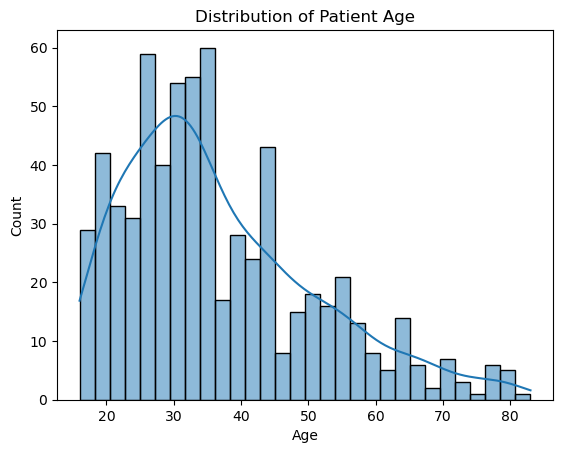

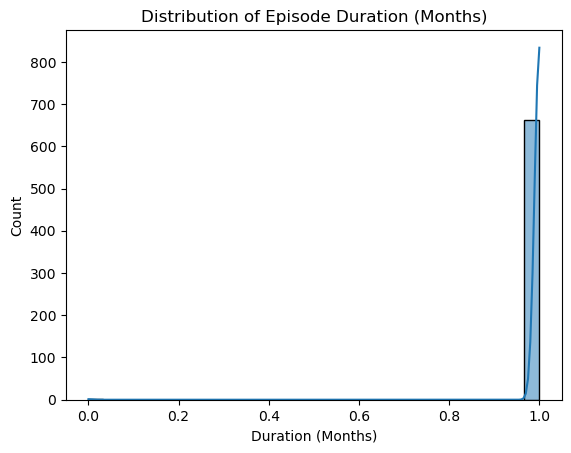

In [138]:

sns.histplot(df['AGE'], kde=True, bins=30)
plt.title("Distribution of Patient Age")
plt.xlabel("Age")
plt.ylabel("Count")
plt.savefig('my_plot_AGE.png', dpi=300, bbox_inches='tight') 
plt.show()

# Duration of Episode
sns.histplot(df['DUR_EPIS'], kde=True, bins=30)
plt.title("Distribution of Episode Duration (Months)")
plt.xlabel("Duration (Months)")
plt.ylabel("Count")
plt.savefig('my_plot_DUR_EPIS.png', dpi=300, bbox_inches='tight') 
plt.show()


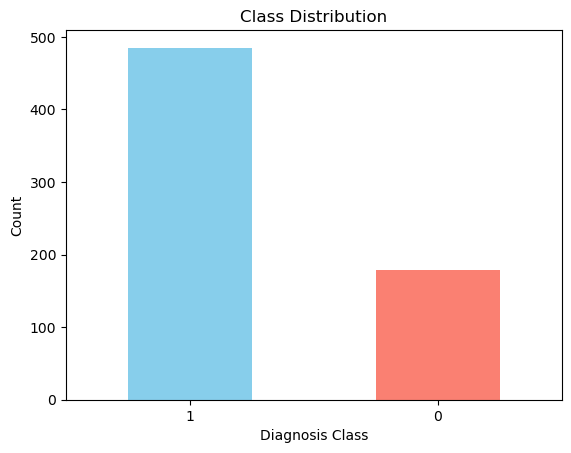

In [139]:
df['CLASS'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Class Distribution")
plt.xlabel("Diagnosis Class")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.savefig('my_plot_bar.png', dpi=300, bbox_inches='tight') 
plt.show()


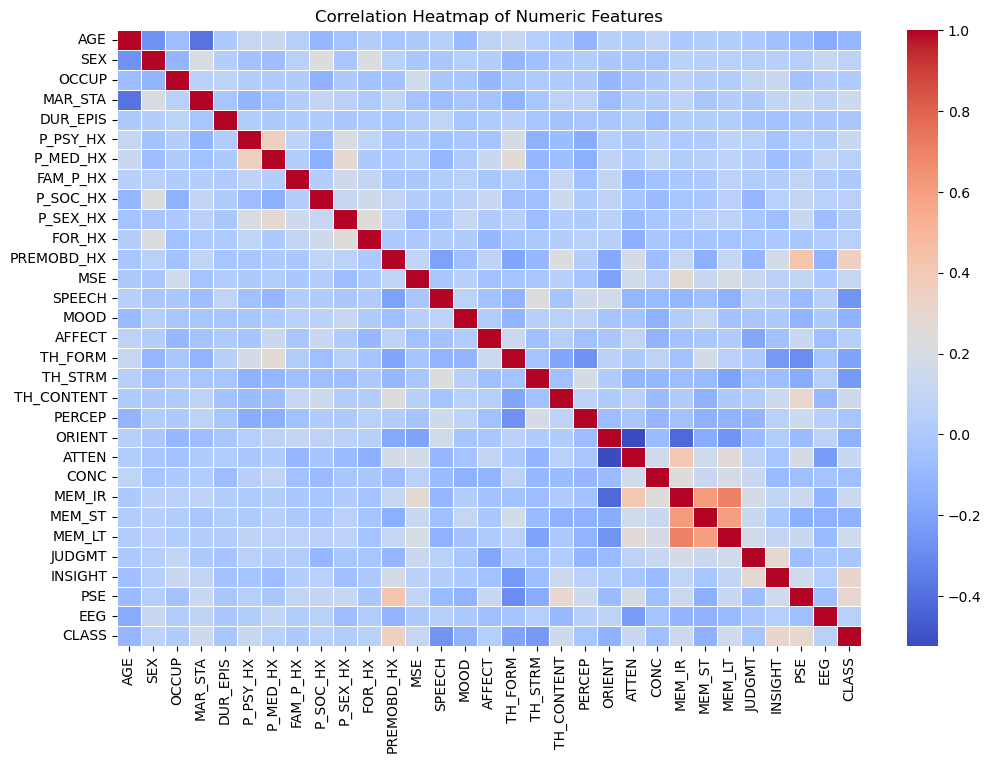

In [140]:
# Correlation matrix for numeric features
corr = df.select_dtypes('number').corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.savefig('my_plot.png', dpi=300, bbox_inches='tight') 
plt.show()


In [141]:
# Split into input and output
X = df.drop("CLASS", axis=1)
y = df["CLASS"]


In [142]:
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

In [143]:
model = RandomForestClassifier(random_state=42)
model.fit(X_tr, y_tr)

RandomForestClassifier(random_state=42)

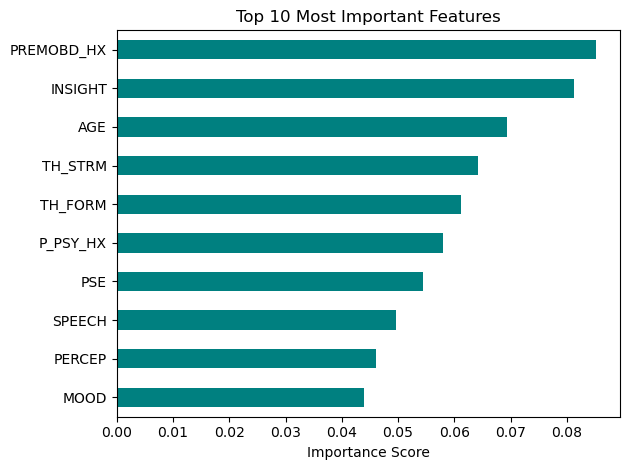

In [144]:
feat_imp = pd.Series(model.feature_importances_, index=X.columns)
top_10 = feat_imp.nlargest(10)

# Plot
top_10.plot(kind='barh', color='teal')
plt.title("Top 10 Most Important Features")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('my_plot_invert_bar.png', dpi=300, bbox_inches='tight')
plt.show()

In [145]:
print("Accuracy →", accuracy_score(y_te, model.predict(X_te)))
print(classification_report(y_te, model.predict(X_te)))

Accuracy → 0.9172932330827067
              precision    recall  f1-score   support

           0       0.96      0.72      0.83        36
           1       0.91      0.99      0.95        97

    accuracy                           0.92       133
   macro avg       0.93      0.86      0.89       133
weighted avg       0.92      0.92      0.91       133



In [146]:
defaults = {}
for col in X.columns:
    if col in label_encoders:
        le = label_encoders[col]      
        if "UNKNOWN" in le.classes_:
            defaults[col] = le.transform(["UNKNOWN"])[0]
        else:     
            defaults[col] = X[col].mode()[0]      
    else:
        defaults[col] = df[col].median

In [147]:
joblib.dump(
    {"model": model,
     "encoders": label_encoders,
     "defaults": defaults,
     "feature_names": X.columns.tolist()},
    "schizo_model.pkl"
)

['schizo_model.pkl']